In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [4]:
%%time
df = pd.read_excel('http://dataevents.hu/202303/filedataevents/competition_table.xlsx', engine='openpyxl')

Wall time: 2min 33s


In [5]:
df = df[(df.odds_home_team_win != 0) & (df.odds_draw != 0) & (df.odds_away_team_win != 0)]

In [6]:
df['home_team_relative_point_roll1_sum'] = df.home_team_point_roll1_sum - df.home_team_expected_point_roll1_sum
df['home_team_relative_point_roll2_sum'] = df.home_team_point_roll2_sum - df.home_team_expected_point_roll2_sum
df['home_team_relative_point_roll3_sum'] = df.home_team_point_roll3_sum - df.home_team_expected_point_roll3_sum
df['home_team_relative_point_roll4_sum'] = df.home_team_point_roll4_sum - df.home_team_expected_point_roll4_sum

In [7]:
df['away_team_relative_point_roll1_sum'] = df.away_team_point_roll1_sum - df.away_team_expected_point_roll1_sum
df['away_team_relative_point_roll2_sum'] = df.away_team_point_roll2_sum - df.away_team_expected_point_roll2_sum
df['away_team_relative_point_roll3_sum'] = df.away_team_point_roll3_sum - df.away_team_expected_point_roll3_sum
df['away_team_relative_point_roll4_sum'] = df.away_team_point_roll4_sum - df.away_team_expected_point_roll4_sum

In [8]:
df['prob_home_win'] = 1 / df.odds_home_team_win
df['prob_draw'] = 1 / df.odds_draw
df['prob_away_win'] = 1 / df.odds_away_team_win

In [9]:
x_variables = set(df.columns)

In [10]:
remove = set(['home_win_flag', 'draw_flag', 'away_win_flag', 'match_id', 'season'])

In [11]:
x_variables = list(x_variables - remove)

In [12]:
df_f = df.copy()

In [13]:
df = df[df.season.isin(['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022'])]

In [14]:
df_train, df_holdout = train_test_split(df, train_size=0.8, random_state=2023)

In [15]:
y, X = dmatrices("home_win_flag ~ " + " + ".join(x_variables), df_train)

### Home Win Flag

**training**

In [16]:
gbm_broad = HistGradientBoostingClassifier()

In [17]:
tune_grid = {
    "max_iter": [50, 100, 200],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_leaf": [5, 10, 20, 30],
}

gbm_model_cv_broad = GridSearchCV(
    gbm_broad,
    tune_grid,
    cv=5,
    scoring="roc_auc",
    verbose=10,
)

In [18]:
categorical_columns =  ['div']
numerical_columns = [col for col in x_variables if col != 'div']

In [19]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_broad = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv_broad)], verbose=True
)

In [20]:
%%time

gbm_pipe_broad.fit(df_train[x_variables], df_train.home_win_flag)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5
[CV 1/5; 1/108] END learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5;, score=0.688 total time=   0.4s
[CV 2/5; 1/108] START learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5
[CV 2/5; 1/108] END learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5;, score=0.690 total time=   0.4s
[CV 3/5; 1/108] START learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5
[CV 3/5; 1/108] END learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5;, score=0.671 total time=   0.4s
[CV 4/5; 1/108] START learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5
[CV 4/5; 1/108] END learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5;, score=0.690 total time=   0.4s
[CV 5/5; 1/108] START learning_rate=0.1, max_depth=1, 

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['div']),
                                                 ('num', 'passthrough',
                                                  ['odds_home_team_win_roll3_mean',
                                                   'home_team_goal_roll4_sum',
                                                   'home_team_opponents_shot_on_target_roll2_sum',
                                                   'home_team_opponents_corner_roll3_sum',
                                                   'prob_draw',
                                                   'home_team_point_roll2_sum',
                                                   'odds_home_team_draw_roll2...
                                                   'away_team_shot_roll1_sum',
                                 

In [21]:
gbm_model_cv_broad.best_score_

0.6850809409303806

**prediction**

In [22]:
y_pred = gbm_pipe_broad.predict_proba(df_holdout[x_variables])

In [23]:
roc_auc_score(df_holdout.home_win_flag, y_pred[:,1])

0.6953905918362787

In [24]:
df_roc = pd.DataFrame({'FPR': roc_curve(df_holdout.home_win_flag, y_pred[:,1])[0], 
                       'TPR': roc_curve(df_holdout.home_win_flag, y_pred[:,1])[1], 
                      'threshold' : roc_curve(df_holdout.home_win_flag, y_pred[:,1])[2]}
                     )

In [25]:
df_roc['FPR_TPR_dif'] = df_roc.TPR - df_roc.FPR

In [26]:
df_roc = df_roc.iloc[1:]

In [27]:
df_roc['FPR_TPR_dif'].idxmax()

194

In [28]:
df_roc.iloc[140:160]

,FPR,TPR,threshold,FPR_TPR_dif
141,0.222480,0.478846,0.464183,0.256366
142,0.223642,0.480385,0.464171,0.256742
143,0.229451,0.487692,0.463652,0.258241
144,0.229451,0.488077,0.461823,0.258626
145,0.231484,0.489231,0.461445,0.257747
146,0.231484,0.489615,0.460432,0.258131
147,0.241940,0.496923,0.459616,0.254983
148,0.242521,0.496923,0.457412,0.254402
149,0.242812,0.499615,0.456894,0.256804
150,0.243392,0.500385,0.456881,0.256992


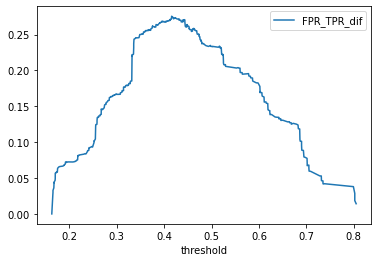

In [29]:
df_roc.plot(kind = 'line', x = 'threshold', y = 'FPR_TPR_dif');

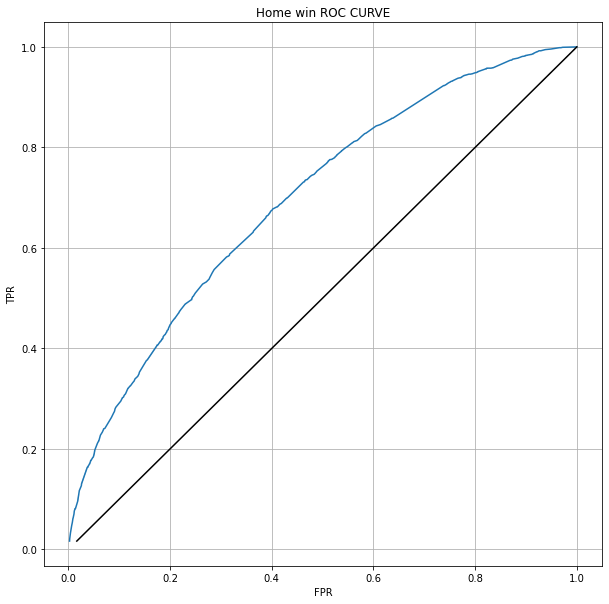

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
p1 = sns.lineplot(data = df_roc, y = 'TPR', x = 'FPR', ax=ax)
p2 = sns.lineplot(data = df_roc, y = 'TPR', x = 'TPR', color = 'k', ax=ax)
plt.title("Home win ROC CURVE")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid('both')

#### Train prediction

In [31]:
y_pred_train = gbm_pipe_broad.predict_proba(df_train[x_variables])

In [32]:
roc_auc_score(df_train.home_win_flag, y_pred_train[:,1])

0.6878968508463739

In [33]:
df_train_result = df_train.copy()

In [41]:
df_train_result['home_win_predict_prob'] = y_pred_train[:,1]

#### Conditional distributions on home_win_flag

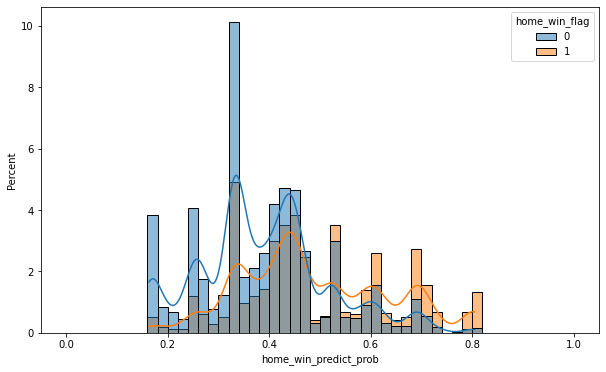

In [59]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax = ax, data = df_train_result, x = 'home_win_predict_prob', hue = 'home_win_flag', kde = True, 
            stat = 'percent', bins = 50, binrange = (0,1));

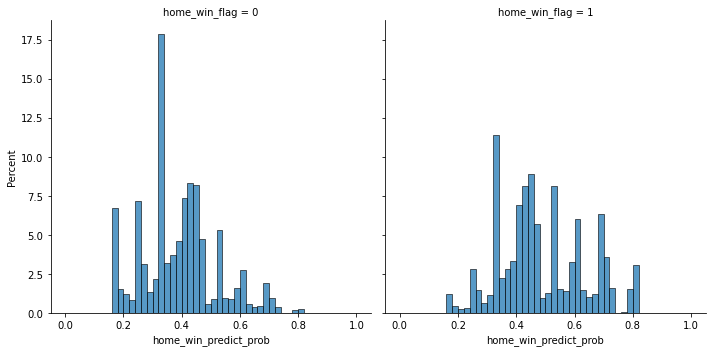

In [53]:
g = sns.FacetGrid(df_train_result, col="home_win_flag", height = 5)
g.map(sns.histplot, "home_win_predict_prob", stat = 'percent', bins = 50, binrange = (0,1));

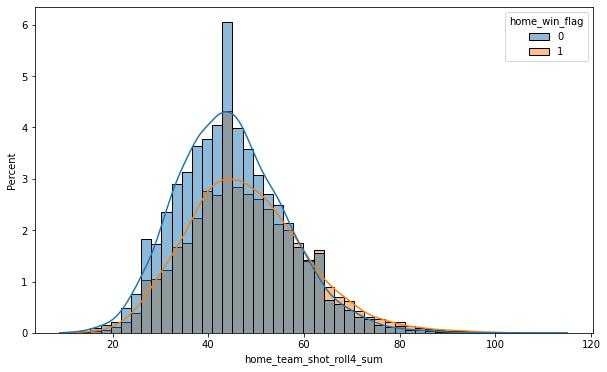

In [84]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax = ax, data = df_train_result, x = 'home_team_shot_roll4_sum', hue = 'home_win_flag', kde = True, 
            stat = 'percent', bins = 50);

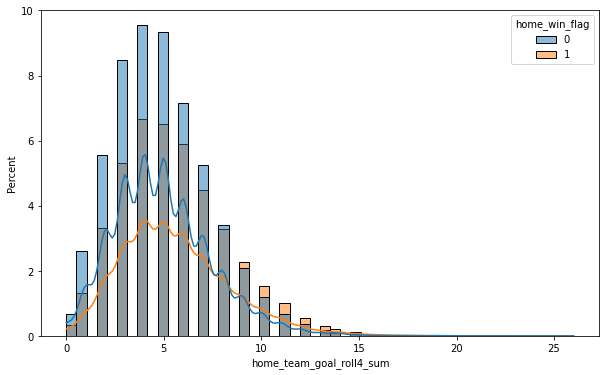

In [70]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax = ax, data = df_train_result, x = 'home_team_goal_roll4_sum', hue = 'home_win_flag', kde = True, 
            stat = 'percent', bins = 50);

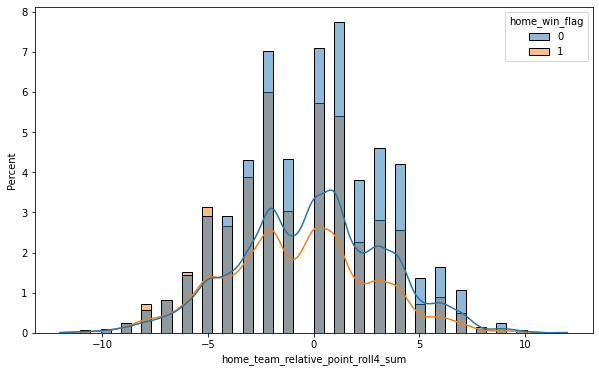

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax = ax, data = df_train_result, x = 'home_team_relative_point_roll4_sum', hue = 'home_win_flag', kde = True, 
            stat = 'percent', bins = 50);

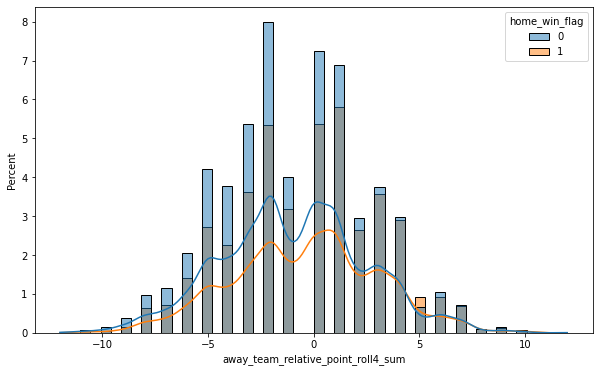

In [83]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax = ax, data = df_train_result, x = 'away_team_relative_point_roll4_sum', hue = 'home_win_flag', kde = True, 
            stat = 'percent', bins = 50);

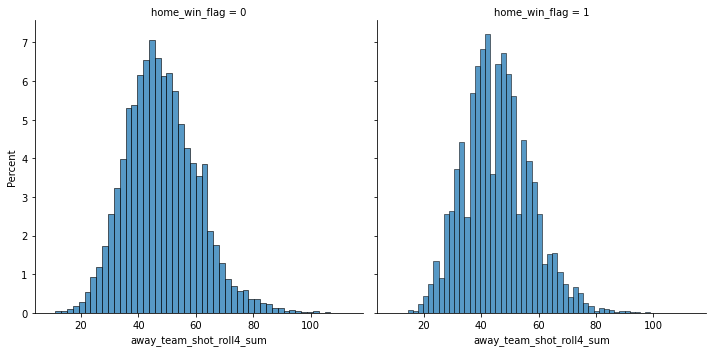

In [62]:
g = sns.FacetGrid(df_train_result, col="home_win_flag", height = 5)
g.map(sns.histplot, "away_team_shot_roll4_sum", stat = 'percent', bins = 50);

In [46]:
df_train_result.away_win_flag.mean()

0.3051050802581499

In [47]:
df_train_result.draw_flag.mean()

0.2622455733907

In [35]:
lr_model.score(x_holdout_normalized, y_holdout)

0.6875588190403452

In [91]:
y_pred = gbm_pipe_broad.predict(df_train[x_variables])

In [94]:
y_pred[0:20]

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
      dtype=int64)

In [93]:
np.mean(y_pred)

0.27796624193281483

In [41]:
confusion_matrix(y_holdout, y_pred).ravel()

array([5696, 1561, 2981, 2594], dtype=int64)

In [44]:
roc_auc_score(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])

0.6875588190403452

In [50]:
roc_curve(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])[2]

array([1.95879395, 0.95879395, 0.92885368, ..., 0.06164526, 0.05806626,
       0.03968204])

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
df_roc = pd.DataFrame({'FPR': roc_curve(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])[0], 
                       'TPR': roc_curve(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])[1], 
                      'threshold' : roc_curve(y_holdout, lr_model.predict_proba(x_holdout_normalized)[:,1])[2]}
                     )

In [62]:
df_roc

,FPR,TPR,threshold
0,0.000000,0.000000,1.958794
1,0.000000,0.000179,0.958794
2,0.000000,0.002870,0.928854
3,0.000138,0.002870,0.924839
4,0.000138,0.003587,0.913676
...,...,...,...
5683,0.996968,0.999641,0.080755
5684,0.996968,0.999821,0.080069
5685,0.999311,0.999821,0.061645
5686,0.999311,1.000000,0.058066


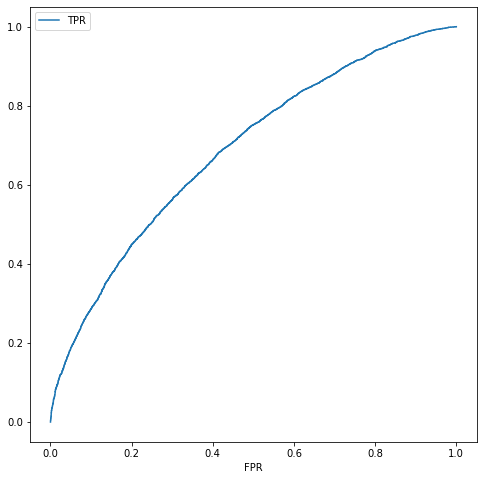

In [54]:
df_roc.plot(kind = 'line', x = 'FPR', y = 'TPR', figsize = (8,8))

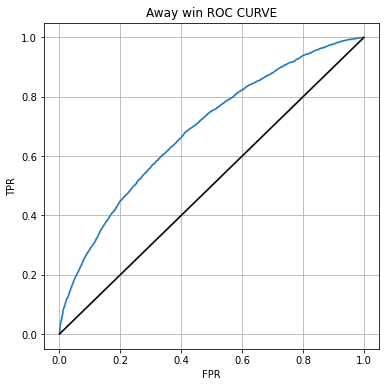

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))
p1 = sns.lineplot(y = df_roc.TPR, x = df_roc.FPR, ax=ax)
p2 = sns.lineplot(y = df_roc.FPR, x = df_roc.FPR, color='k', ax=ax)
plt.title("Away win ROC CURVE")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid('both')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
p1 = sns.lineplot(y = df_roc.TPR, x = df_roc.threshold, label = 'TPR', ax=ax)
p2 = sns.lineplot(y = df_roc.FPR, x = df_roc.threshold, label = 'FPR', color='k', ax=ax)
plt.title("Away win ROC CURVE")
plt.xlabel('threshold')
plt.xlim(0,1)
plt.legend()
plt.ylabel('TPR')
plt.grid('both')

In [85]:
df_train.home_win_flag.mean()

0.4326493463511501

In [86]:
df_train.away_win_flag.mean()

0.3051050802581499

In [87]:
df_train.draw_flag.mean()

0.2622455733907